In [1]:
import ray
ray.init()

2023-08-02 17:45:58,772	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.9.17
Ray version:,2.6.1
Dashboard:,http://127.0.0.1:8265


In [2]:
resources = ray.cluster_resources()
print(resources)

{'node:__internal_head__': 1.0, 'CPU': 20.0, 'node:172.21.2.236': 1.0, 'memory': 2886716622.0, 'object_store_memory': 1443358310.0}


In [3]:
import gymnasium as gym
import numpy as np

class SeededFetchPickAndPlaceEnv(gym.Wrapper):
    def __init__(self, env, seed=None):
        super().__init__(env)
        self.seed = seed

    def reset(self, seed=None, options=None):
        obs, info = self.env.reset(seed=self.seed)
        return obs, info

    def seed(self, seed=None):
        self.np_random, seed = np.random.SeedSequence(seed)
        return [seed]

# Usage:
#env = gym.make('FetchPickAndPlace-v2')
#wrapped_env = SeededFetchPickAndPlaceEnv(env, 959)


In [4]:
#env = gym.make('FrankaPickPlaceFixed-v0')

In [5]:
def env_creator(env_config={}):
    import gymnasium as gym
    env = gym.make('FetchPickAndPlace-v2', render_mode='rgb_array', reward_type='dense', max_episode_steps=100)
    env = SeededFetchPickAndPlaceEnv(env, 960)
    env.reset()
    return env

In [6]:
from ray.tune.registry import register_env
register_env("Gymnasium_Pick_Place_0_Dense_Single_Task", env_creator)

In [7]:
# Serialize with cloudpickle and save to a file
#with open("Gymnasium_Pick_Place_0.pkl", "wb") as f:
   # cloudpickle.dump(env_creator, f)

In [8]:
from ray import tune

In [9]:
tune.run("PPO",
             # algorithm specific configuration
             config={"env": "Gymnasium_Pick_Place_0_Dense_Single_Task",  #
                     "framework": "torch",
                     #"seed":958,
                     "num_gpus": 1,
                     "num_rollout_workers": 4,
                     #"num_envs_per_worker": 1,
                     #"num_gpus_per_worker": 0,
                     "train_batch_size": 512,
                     "use_critic":True,
                     "use_gae": True,
                     "lambda": 0.99,
                     "sgd_minibatch_size": 32,
                     "num_sgd_iter": 8,
                     "shuffle_sequences": False,
                     "entropy_coeff": 0.00015,
                     "clip_param": 0.1,
                     "grad_clip": 5,
                     "lr": 0.00015,
                     #"num_cpus_per_worker": 1,
                     #"model": {"custom_model": "pa_model", },
                     "use_attention": True,
                     "evaluation_interval": 1,
                     "evaluation_num_episodes": 2,
                     "evaluation_parallel_to_training": True,
                     "evaluation_num_workers": 1,
                     "disable_env_checking":True
                     },
             local_dir="../R3L-LOGS",  # directory to save results
             checkpoint_freq=2,  # frequency between checkpoints
             keep_checkpoints_num=6,
             stop={"training_iteration": 500}
             )

2023-08-02 17:46:03,491	INFO tune.py:657 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
/home/cocp5/anaconda3/envs/R3L/lib/python3.9/site-packages/ray/tune/tune.py:258: UserWarning: Passing a `local_dir` is deprecated and will be removed in the future. Pass `storage_path` instead or set the `RAY_AIR_LOCAL_CACHE_DIR` environment variable instead.
  warnings.warn(
2023-08-02 17:46:05,960	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!
2023-08-02 17:46:06,052	WARNING deprecation.py:50 -- DeprecationWarning: `build_tf_policy` has been deprecated. This will raise an error in the future!
2023-08-02 17:46:06,055	WARNING deprecation.py:50 -- DeprecationWarning: `build_policy_class` has been deprecated. This will raise an error in the future!
2023-08-02 1

2023-08-02 17:46:06,184	WARNING algorithm_config.py:2534 -- Setting `exploration_config={}` because you set `_enable_rl_module_api=True`. When RLModule API are enabled, exploration_config can not be set. If you want to implement custom exploration behaviour, please modify the `forward_exploration` method of the RLModule at hand. On configs that have a default exploration config, this must be done with `config.exploration_config={}`.
2023-08-02 17:46:06,184	WARNING algorithm_config.py:656 -- Cannot create PPOConfig from given `config_dict`! Property use_attention not supported.
2023-08-02 17:46:06,185	WARNING deprecation.py:50 -- DeprecationWarning: `AlgorithmConfig.evaluation(evaluation_num_episodes=..)` has been deprecated. Use `AlgorithmConfig.evaluation(evaluation_duration=.., evaluation_duration_unit='episodes')` instead. This will raise an error in the future!
(pid=25327) DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!
(PPO pi

Trial name,agent_timesteps_total,connector_metrics,counters,custom_metrics,episode_len_mean,episode_media,episode_reward_max,episode_reward_mean,episode_reward_min,episodes_this_iter,evaluation,info,num_agent_steps_sampled,num_agent_steps_trained,num_env_steps_sampled,num_env_steps_sampled_this_iter,num_env_steps_sampled_throughput_per_sec,num_env_steps_trained,num_env_steps_trained_this_iter,num_env_steps_trained_throughput_per_sec,num_faulty_episodes,num_healthy_workers,num_in_flight_async_reqs,num_remote_worker_restarts,num_steps_trained_this_iter,perf,policy_reward_max,policy_reward_mean,policy_reward_min,sampler_perf,sampler_results,timers
PPO_Gymnasium_Pick_Place_0_Dense_Single_Task_130c1_00000,256000,"{'ObsPreprocessorConnector_ms': 0.02107095718383789, 'StateBufferConnector_ms': 0.003962993621826172, 'ViewRequirementAgentConnector_ms': 0.20429420471191406}","{'num_env_steps_sampled': 256000, 'num_env_steps_trained': 0, 'num_agent_steps_sampled': 256000, 'num_agent_steps_trained': 0}",{},100,{},-37.5294,-37.5294,-37.5294,8,"{'sampler_results': {'episode_reward_max': -37.529422833240055, 'episode_reward_min': -37.529422833240055, 'episode_reward_mean': -37.529422833240055, 'episode_len_mean': 100.0, 'episode_media': {}, 'episodes_this_iter': 2, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [-37.529422833240055, -37.529422833240055], 'episode_lengths': [100, 100]}, 'sampler_perf': {'mean_raw_obs_processing_ms': 0.34752086494409107, 'mean_inference_ms': 0.9371816305526216, 'mean_action_processing_ms': 0.13774743615478885, 'mean_env_wait_ms': 1.4419844266866475, 'mean_env_render_ms': 0.0}, 'num_faulty_episodes': 0, 'connector_metrics': {'ObsPreprocessorConnector_ms': 0.022399425506591797, 'StateBufferConnector_ms': 0.003612041473388672, 'ViewRequirementAgentConnector_ms': 0.20821094512939453}}, 'episode_reward_max': -37.529422833240055, 'episode_reward_min': -37.529422833240055, 'episode_reward_mean': -37.529422833240055, 'episode_len_mean': 100.0, 'episode_media': {}, 'episodes_this_iter': 2, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [-37.529422833240055, -37.529422833240055], 'episode_lengths': [100, 100]}, 'sampler_perf': {'mean_raw_obs_processing_ms': 0.34752086494409107, 'mean_inference_ms': 0.9371816305526216, 'mean_action_processing_ms': 0.13774743615478885, 'mean_env_wait_ms': 1.4419844266866475, 'mean_env_render_ms': 0.0}, 'num_faulty_episodes': 0, 'connector_metrics': {'ObsPreprocessorConnector_ms': 0.022399425506591797, 'StateBufferConnector_ms': 0.003612041473388672, 'ViewRequirementAgentConnector_ms': 0.20821094512939453}, 'num_agent_steps_sampled_this_iter': 200, 'num_env_steps_sampled_this_iter': 200, 'timesteps_this_iter': 200, 'num_healthy_workers': 1, 'num_in_flight_async_reqs': 0, 'num_remote_worker_restarts': 0}","{'learner': {'__all__': {'num_agent_steps_trained': 32.0, 'num_env_steps_trained': 512.0, 'total_loss': -0.0024288645945489407}, 'default_policy': {'total_loss': -0.0024288645945489407, 'policy_loss': -0.0017962523270398378, 'vf_loss': 2.7033482052019053e-05, 'vf_loss_unclipped': 2.7033482052019053e-05, 'vf_explained_var': -0.17492486350238323, 'entropy': 4.397573200985789, 'mean_kl_loss': 0.0061601434448448344, 'gradients_default_optimizer_global_norm': 4.410451821982861, 'curr_lr': 0.00015, 'curr_entropy_coeff': 0.00015, 'curr_kl_coeff': 9.94859604667835e-27}}, 'num_env_steps_sampled': 256000, 'num_env_steps_trained': 0, 'num_agent_steps_sampled': 256000, 'num_agent_steps_trained': 0}",256000,0,256000,512,632.841,0,0,0,0,4,0,0,0,"{'cpu_util_percent': 16.15, 'ram_util_percent': 89.6}",{},{},{},"{'mean_raw_obs_processing_ms': 0.3811589160852135, 'mean_inference_ms': 0.978909453069657, 'mean_action_processing_ms': 0.14119104733276674, 'mean_env_wait_ms': 1.5044622914029062, 'mean_env_render_ms': 0.0}","{'episode_reward_max':

2023-08-02 17:52:57,717	INFO tune.py:1148 -- Total run time: 414.22 seconds (410.82 seconds for the tuning loop).


In [10]:
env = env_creator({})

In [11]:
import numpy as np

from ray.rllib.policy.policy import Policy     

# Use the `from_checkpoint` utility of the Policy class:
my_restored_policy = Policy.from_checkpoint("../R3L-LOGS/PPO/PPO_Gymnasium_Pick_Place_0_Dense_Single_Task_130c1_00000_0_2023-08-02_17-46-06/checkpoint_000500/policies/default_policy")

# Use the restored policy for serving actions.
obs,  reward, terminated, truncated, info =   env.step(env.action_space.sample())# individual CartPole observation
#action = my_restored_policy.compute_single_action(np.append(obs.get('observation'), obs.get('achieved_goal'), obs.get('desired_goal')))


2023-08-02 17:57:16,087	WARNING algorithm_config.py:2534 -- Setting `exploration_config={}` because you set `_enable_rl_module_api=True`. When RLModule API are enabled, exploration_config can not be set. If you want to implement custom exploration behaviour, please modify the `forward_exploration` method of the RLModule at hand. On configs that have a default exploration config, this must be done with `config.exploration_config={}`.
2023-08-02 17:57:16,200	WARNING deprecation.py:50 -- DeprecationWarning: `ValueNetworkMixin` has been deprecated. This will raise an error in the future!
2023-08-02 17:57:16,200	WARNING deprecation.py:50 -- DeprecationWarning: `LearningRateSchedule` has been deprecated. This will raise an error in the future!
2023-08-02 17:57:16,201	WARNING deprecation.py:50 -- DeprecationWarning: `EntropyCoeffSchedule` has been deprecated. This will raise an error in the future!
2023-08-02 17:57:16,201	WARNING deprecation.py:50 -- DeprecationWarning: `KLCoeffMixin` has bee

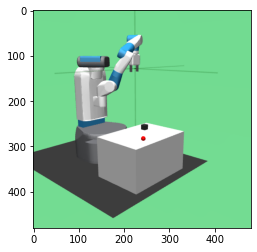

In [13]:
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
img = plt.imshow(env.render())
for i in range(0, 512):
    
    action = my_restored_policy.compute_single_action(np.concatenate([obs.get('observation'), obs.get('desired_goal'), obs.get('achieved_goal')]))

    obs,  reward, terminated, truncated, info =   env.step(env.action_space.sample())# individual CartPole observation

    #print(f"Computed action {action} from given CartPole observation.")
    img.set_data(env.render()) # Just update the data
    ipythondisplay.display(plt.gcf())
    ipythondisplay.clear_output(wait=True)